In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
%matplotlib notebook

# Get network informations

In [3]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [4]:
cluster_labels = pd.read_json('cluster_labels.json')
pressure_factor = pd.read_json('pressure_factor.json')
n_clusters = 30

Get results:

In [5]:
file = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_14_try.pkl'
with open(file, 'rb') as f:
    results = pickle.load(f)

## Physical preprocessing:

### Junctions
Scale pressure for each node (similar to clustering)

In [6]:
junction_pressure_scaled = results.node['pressure'][node_names[2]]/pressure_factor.to_numpy()

In [7]:
jun_cl_press = junction_pressure_scaled.groupby(cluster_labels.loc['pressure'], axis=1)
jun_cl_press_mean = jun_cl_press.mean()
jun_cl_press_std = jun_cl_press.std()

jun_cl_demand = results.node['demand'][node_names[2]].groupby(cluster_labels.loc['pressure'], axis=1)
jun_cl_demand_sum = jun_cl_demand.sum()

jun_cl_qual = results.node['quality'][node_names[2]].diff(axis=0).groupby(cluster_labels.loc['quality'], axis=1)
qual_cl_qual_mean = jun_cl_qual.mean()
qual_cl_qual_std = jun_cl_qual.std()

<IPython.core.display.Javascript object>


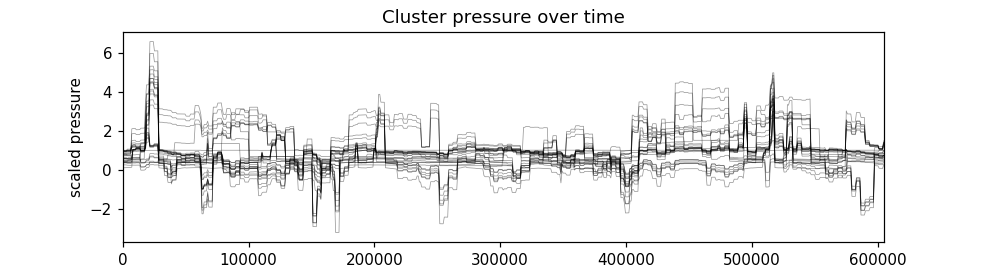

In [8]:
fig, ax = plt.subplots(figsize=(9,2.5))
jun_cl_press_mean.plot(ax=ax, legend=False, linewidth=0.5, color='k', alpha=0.4)
ax.set_xlabel('time [s]')
ax.set_ylabel('scaled pressure')
ax.set_title('Cluster pressure over time')
plt.show()

### Tanks

In [9]:
tank_press = results.node['pressure'][node_names[0]]
# Subtract tank elevation from tank head to obtain tank_level
tank_level = results.node['head'][node_names[0]]-nw_node_df[node_names[0]].loc['elevation']

tank_qual = results.node['quality'][node_names[0]]

<IPython.core.display.Javascript object>


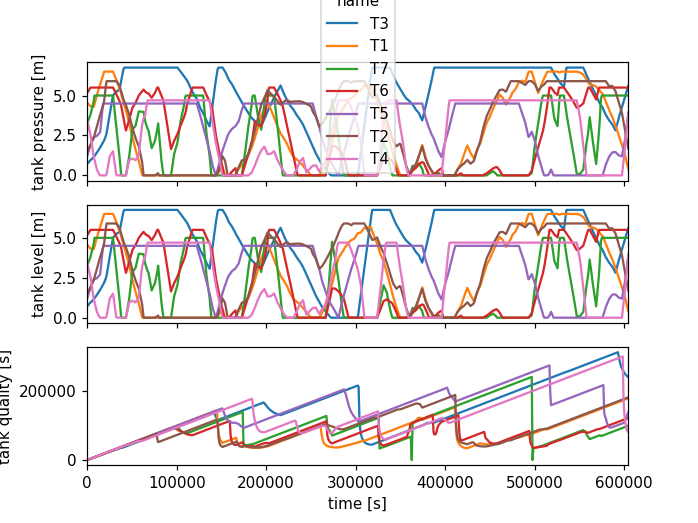

Text(0.5, 0, 'time [s]')

In [10]:
fig, ax = plt.subplots(3,1, sharex=True,)
tank_press.plot(ax=ax[0])
ax[0].set_ylabel('tank pressure [m]')
tank_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('tank level [m]')
tank_qual.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('tank quality [s]')
ax[2].set_xlabel('time [s]')

### Reservoirs

In [11]:
reservoir_press = results.node['pressure'][node_names[1]]
reservoir_level = results.node['head'][node_names[1]]-nw_node_df[node_names[1]].loc['elevation']

reservoir_qual = results.node['quality'][node_names[1]]

<IPython.core.display.Javascript object>


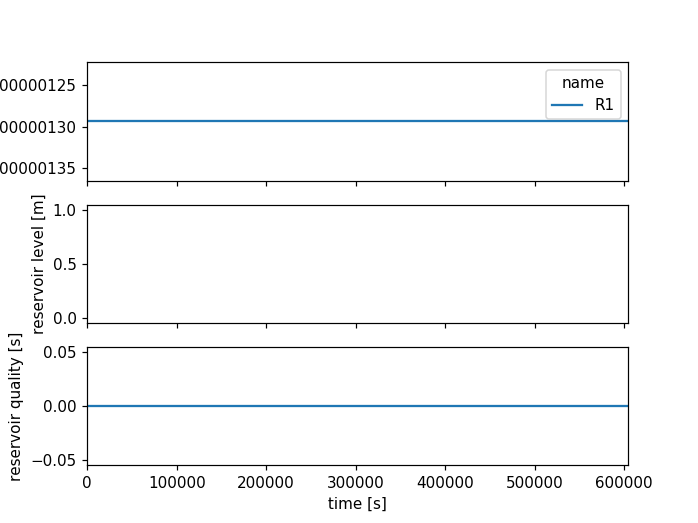

Text(0.5, 0, 'time [s]')

In [12]:
fig, ax = plt.subplots(3,1, sharex=True,)
reservoir_press.plot(ax=ax[0])
ax[0].set_ylabel('reservoir pressure [m]')
reservoir_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('reservoir level [m]')
reservoir_qual.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('reservoir quality [s]')
ax[2].set_xlabel('time [s]')

### Pumps

In [13]:
head_pump_speed = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]

<IPython.core.display.Javascript object>


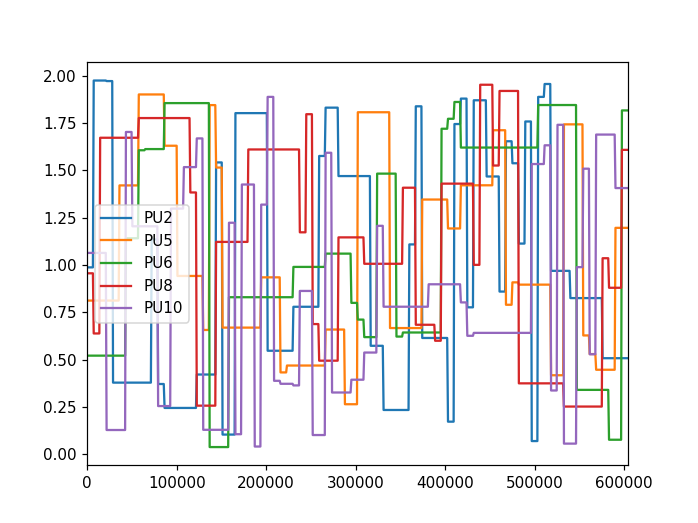

In [14]:
fig, ax = plt.subplots()
head_pump_speed.plot(ax=ax)

In [15]:
pump_energy = economics.pump_energy(results.link['flowrate'], results.node['head'], ctown.wn)[link_names[0]]
pump_energy /= 1000
pump_energy.head(3)

,PU2,PU5,PU6,PU8,PU10
0,58.227444,14.631674,0.0,26.532584,23.435502
900,58.196094,14.636934,0.0,26.524227,23.469185
1800,58.165324,14.641828,0.0,26.515586,23.502525


<IPython.core.display.Javascript object>


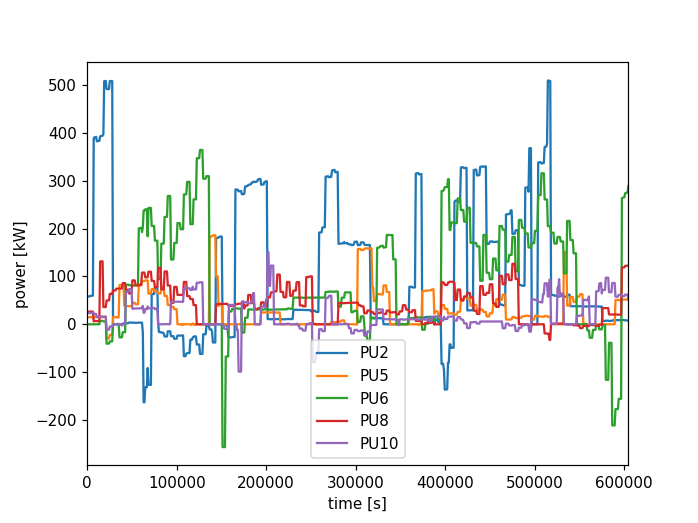

Text(0.5, 0, 'time [s]')

In [16]:
fig, ax = plt.subplots()
pump_energy.plot(ax=ax)
ax.set_ylabel('power [kW]')
ax.set_xlabel('time [s]')

### Valves

In [17]:
PRValve_dp = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

<IPython.core.display.Javascript object>


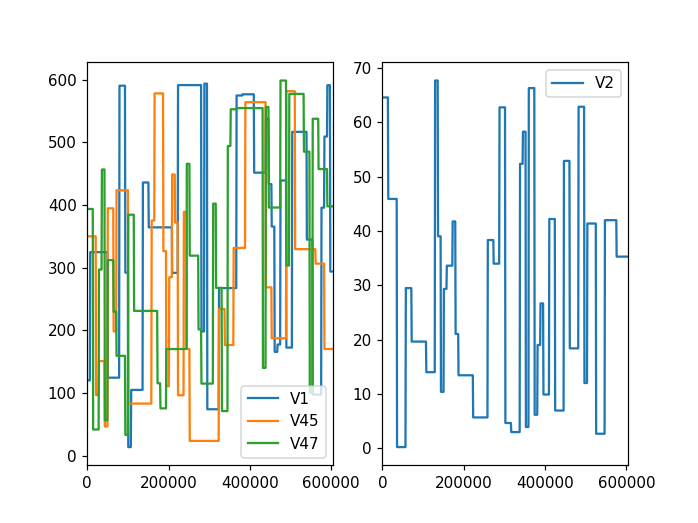

In [18]:
fig, ax = plt.subplots(1,2)
PRValve_dp.plot(ax=ax[0])
TCValve_throttle.plot(ax=ax[1])

## Neural Network Pre-Processing
### States and Inputs

In [19]:
state_dict = {'jun_cl_press_mean': jun_cl_press_mean,
              # 'jun_cl_press_std': jun_cl_press_std,
              # 'dqual_cl_press_mean': dqual_cl_press_mean,
              # 'dqual_cl_press_std': dqual_cl_press_std,
              'tank_press': tank_press,
              # 'tank_level': tank_level,
              # 'tank_qual': tank_qual,
              # 'reservoir_press': reservoir_press,
              # 'reservoir_level': reservoir_level,
              # 'reservoir_qual': reservoir_qual,
              }

sys_states = pd.concat(state_dict.values(), axis=1, keys=state_dict.keys())


input_dict = {'head_pump_speed': head_pump_speed,
              'PRValve_dp': PRValve_dp,
              'TCValve_throttle': TCValve_throttle,
              'jun_cl_demand_sum': jun_cl_demand_sum}

sys_inputs = pd.concat(input_dict.values(), axis=1, keys=input_dict.keys())

aux_output_dict = {'pump_energy': pump_energy,}

aux_outputs = pd.concat(aux_output_dict.values(), axis=1, keys=aux_output_dict.keys())

### Neural Network I/O

Outputs of the neural network.

Note: we are learning the next state of the system and the current aux_outputs (pump energy)

In [20]:
sys_states_next = sys_states.shift(-1, axis=0)

nn_output_dict = {'sys_states': sys_states_next,
                 'aux_outputs': aux_outputs}


nn_output = pd.concat(nn_output_dict.values(), axis=1, keys=nn_output_dict.keys())

In [21]:
nn_output.head(3)

sys_states                                                    \
     jun_cl_press_mean                                                     
                     0         1         2         3         4         5   
0             0.359735  0.942131  0.581662  0.945813  0.902581  0.492358   
900           0.358263  0.941637  0.582362  0.945172  0.901817  0.493456   
1800          0.356845  0.941151  0.583059  0.944541  0.901065  0.494547   

                                              ...                       \
                                              ... tank_press             
             6         7         8         9  ...         T7        T6   
0     0.997837  0.254253  0.578518  0.488985  ...   3.397771  5.253158   
900   0.997174  0.252537  0.580050  0.489438  ...   3.534470  5.334502   
1800  0.996519  0.250848  0.581577  0.489889  ...   3.670313  5.415967   

                                   aux_outputs                             \
                                   pump_energy                              
            T5        T2        T4         PU2        PU5  PU6        PU8   
0     1.385392  1.612929  3.221158   58.227444  14.631674  0.0  26.532584   
900   1.550210  1.715537  2.992232   58.196094  14.636934  0.0  26.524227   
1800  1.714489  1.816875  2.763316   58.165324  14.641828  0.0  26.515586   

                 
                 
           PU10  
0     23.435502  
900   23.469185  
1800  23.502525  

[3 rows x 42 columns]

Inputs of the neural network:

In [22]:
nn_input_dict = {'sys_states': sys_states,
                 'sys_inputs': sys_inputs}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys())

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (673, 76)


NARX model structure?

In [23]:
if True:
    n_arx = 8
    arx_input = []
    for i in range(n_arx):
        arx_input.append(nn_input.shift(i, axis=0))

    arx_input = pd.concat(arx_input, keys=np.arange(n_arx), names=['NARX', 'type', 'name', 'index'], axis=1)
    nn_input = arx_input
print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (673, 608)


In [24]:
nn_input.head(3)

NARX                  0                                                    \
type         sys_states                                                     
name  jun_cl_press_mean                                                     
index                0         1         2         3         4         5    
0              0.361217  0.942634  0.580960  0.946468  0.903360  0.491254   
900            0.359735  0.942131  0.581662  0.945813  0.902581  0.492358   
1800           0.358263  0.941637  0.582362  0.945172  0.901817  0.493456   

NARX                                           ...                 7          \
type                                           ...        sys_inputs           
name                                           ... jun_cl_demand_sum           
index        6         7         8         9   ...                20  21  22   
0      0.998509  0.255970  0.576981  0.488532  ...               NaN NaN NaN   
900    0.997837  0.254253  0.578518  0.488985  ...               NaN NaN NaN   
1800   0.997174  0.252537  0.580050  0.489438  ...               NaN NaN NaN   

NARX                               
type                               
name                               
index  23  24  25  26  27  28  29  
0     NaN NaN NaN NaN NaN NaN NaN  
900   NaN NaN NaN NaN NaN NaN NaN  
1800  NaN NaN NaN NaN NaN NaN NaN  

[3 rows x 608 columns]

Check if NARX structure works:

In [25]:
nn_input.xs(('sys_states',slice(0)),level=('type','index'), axis=1).head(5)

NARX,0,1,2,3,4,5,6,7
name,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean
0,0.361217,NaN,NaN,NaN,NaN,NaN,NaN,NaN
900,0.359735,0.361217,NaN,NaN,NaN,NaN,NaN,NaN
1800,0.358263,0.359735,0.361217,NaN,NaN,NaN,NaN,NaN
2700,0.356845,0.358263,0.359735,0.361217,NaN,NaN,NaN,NaN
3600,0.329629,0.356845,0.358263,0.359735,0.361217,NaN,NaN,NaN


Filter inputs and outputs:

In [26]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (665, 608)


In [27]:
print(nn_input.isnull().any().any())
print(nn_output.isnull().any().any())

False
False


In [28]:
nn_input.xs(('sys_states',slice(0)),level=('type','index'), axis=1).head(3)

NARX,0,1,2,3,4,5,6,7
name,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean
6300,0.322979,0.325200,0.327420,0.329629,0.356845,0.358263,0.359735,0.361217
7200,0.351405,0.322979,0.325200,0.327420,0.329629,0.356845,0.358263,0.359735
8100,0.350054,0.351405,0.322979,0.325200,0.327420,0.329629,0.356845,0.358263


In [29]:
pd.DataFrame(nn_output['sys_states','jun_cl_press_mean',0]).head(3)

,sys_states
,jun_cl_press_mean
,0
6300,0.351405
7200,0.350054
8100,0.348764


### Compare to external output function:

This function is used to create the complete dataset for training.

In [30]:
file_list = ['/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_14_try.pkl',
            #'/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_15_try.pkl',
            #'/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_16_try.pkl',
            #'/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_17_try.pkl'
            ]

nn_input_ext, nn_output_ext = get_data(file_list, narx_horizon=n_arx)

In [31]:
similar_inputs=((nn_input_ext-nn_input)==0).all().all()
print('inputs are identical: {}'.format(similar_inputs))

similar_outputs=((nn_output_ext-nn_output)==0).all().all()
print('outputs are identical: {}'.format(similar_outputs))

inputs are identical: True
outputs are identical: True


### Normalize Data:

In [32]:
input_offset = nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

### Train / Test Splitting

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [34]:
X_train.shape

(532, 608)

# Neural Network

## Create Model

In [35]:
n_layer = 3
n_units = 70
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 608)]             0         
_________________________________________________________________
dense (Dense)                (None, 70)                42630     
_________________________________________________________________
dense_1 (Dense)              (None, 70)                4970      
_________________________________________________________________
dense_2 (Dense)              (None, 42)                2982      
Total params: 50,582
Trainable params: 50,582
Non-trainable params: 0
_________________________________________________________________


## Train model

In [36]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [37]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=100, 
                    epochs=1000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),
                    callbacks=[callback])

Train on 532 samples, validate on 133 samples
Epoch 1/1000
532/532 [==============================] - 1s 2ms/sample - loss: 0.2124 - val_loss: 0.1275
Epoch 2/1000
532/532 [==============================] - 0s 191us/sample - loss: 0.1059 - val_loss: 0.0805
Epoch 3/1000
532/532 [==============================] - 0s 163us/sample - loss: 0.0696 - val_loss: 0.0587
Epoch 4/1000
532/532 [==============================] - 0s 216us/sample - loss: 0.0519 - val_loss: 0.0472
Epoch 5/1000
532/532 [==============================] - 0s 230us/sample - loss: 0.0414 - val_loss: 0.0401
Epoch 6/1000
532/532 [==============================] - 0s 220us/sample - loss: 0.0347 - val_loss: 0.0349
Epoch 7/1000
532/532 [==============================] - 0s 217us/sample - loss: 0.0304 - val_loss: 0.0315
Epoch 8/1000
532/532 [==============================] - 0s 187us/sample - loss: 0.0271 - val_loss: 0.0288
Epoch 9/1000
532/532 [==============================] - 0s 175us/sample - loss: 0.0245 - val_loss: 0.0265
Ep

532/532 [==============================] - 0s 218us/sample - loss: 0.0049 - val_loss: 0.0107
Epoch 78/1000
532/532 [==============================] - 0s 136us/sample - loss: 0.0050 - val_loss: 0.0106
Epoch 79/1000
532/532 [==============================] - 0s 205us/sample - loss: 0.0049 - val_loss: 0.0108
Epoch 80/1000
532/532 [==============================] - 0s 210us/sample - loss: 0.0051 - val_loss: 0.0109
Epoch 81/1000
532/532 [==============================] - 0s 164us/sample - loss: 0.0052 - val_loss: 0.0111
Epoch 82/1000
532/532 [==============================] - 0s 160us/sample - loss: 0.0051 - val_loss: 0.0106
Epoch 83/1000
532/532 [==============================] - 0s 138us/sample - loss: 0.0049 - val_loss: 0.0108
Epoch 84/1000
532/532 [==============================] - 0s 185us/sample - loss: 0.0048 - val_loss: 0.0107
Epoch 85/1000
532/532 [==============================] - 0s 208us/sample - loss: 0.0046 - val_loss: 0.0103
Epoch 86/1000
532/532 [============================

532/532 [==============================] - 0s 171us/sample - loss: 0.0031 - val_loss: 0.0103
Epoch 154/1000
532/532 [==============================] - 0s 180us/sample - loss: 0.0031 - val_loss: 0.0097
Epoch 155/1000
532/532 [==============================] - 0s 191us/sample - loss: 0.0031 - val_loss: 0.0100
Epoch 156/1000
532/532 [==============================] - 0s 222us/sample - loss: 0.0029 - val_loss: 0.0098
Epoch 157/1000
532/532 [==============================] - 0s 200us/sample - loss: 0.0029 - val_loss: 0.0097
Epoch 158/1000
532/532 [==============================] - 0s 181us/sample - loss: 0.0028 - val_loss: 0.0098
Epoch 159/1000
532/532 [==============================] - 0s 201us/sample - loss: 0.0028 - val_loss: 0.0100
Epoch 160/1000
532/532 [==============================] - 0s 175us/sample - loss: 0.0029 - val_loss: 0.0096
Epoch 161/1000
532/532 [==============================] - 0s 189us/sample - loss: 0.0029 - val_loss: 0.0102
Epoch 162/1000
532/532 [===================

Epoch 229/1000
532/532 [==============================] - 0s 151us/sample - loss: 0.0019 - val_loss: 0.0096
Epoch 230/1000
532/532 [==============================] - 0s 125us/sample - loss: 0.0019 - val_loss: 0.0095
Epoch 231/1000
532/532 [==============================] - 0s 132us/sample - loss: 0.0019 - val_loss: 0.0095
Epoch 232/1000
532/532 [==============================] - 0s 142us/sample - loss: 0.0018 - val_loss: 0.0096
Epoch 233/1000
532/532 [==============================] - 0s 130us/sample - loss: 0.0018 - val_loss: 0.0098
Epoch 234/1000
532/532 [==============================] - 0s 133us/sample - loss: 0.0019 - val_loss: 0.0100
Epoch 235/1000
532/532 [==============================] - 0s 145us/sample - loss: 0.0020 - val_loss: 0.0100
Epoch 236/1000
532/532 [==============================] - 0s 123us/sample - loss: 0.0020 - val_loss: 0.0099
Epoch 237/1000
532/532 [==============================] - 0s 134us/sample - loss: 0.0020 - val_loss: 0.0097
Epoch 238/1000
532/532 [====

Epoch 305/1000
532/532 [==============================] - 0s 187us/sample - loss: 0.0014 - val_loss: 0.0095
Epoch 306/1000
532/532 [==============================] - 0s 215us/sample - loss: 0.0013 - val_loss: 0.0094
Epoch 307/1000
532/532 [==============================] - 0s 178us/sample - loss: 0.0013 - val_loss: 0.0096
Epoch 308/1000
532/532 [==============================] - 0s 183us/sample - loss: 0.0013 - val_loss: 0.0095
Epoch 309/1000
532/532 [==============================] - 0s 236us/sample - loss: 0.0013 - val_loss: 0.0092
Epoch 310/1000
532/532 [==============================] - 0s 199us/sample - loss: 0.0013 - val_loss: 0.0094
Epoch 311/1000
532/532 [==============================] - 0s 179us/sample - loss: 0.0013 - val_loss: 0.0095
Epoch 312/1000
532/532 [==============================] - 0s 177us/sample - loss: 0.0013 - val_loss: 0.0095
Epoch 313/1000
532/532 [==============================] - 0s 189us/sample - loss: 0.0013 - val_loss: 0.0095
Epoch 314/1000
532/532 [====

Epoch 381/1000
532/532 [==============================] - 0s 167us/sample - loss: 0.0012 - val_loss: 0.0095
Epoch 382/1000
532/532 [==============================] - 0s 172us/sample - loss: 0.0012 - val_loss: 0.0093
Epoch 383/1000
532/532 [==============================] - 0s 166us/sample - loss: 0.0011 - val_loss: 0.0093
Epoch 384/1000
532/532 [==============================] - 0s 204us/sample - loss: 0.0010 - val_loss: 0.0093
Epoch 385/1000
532/532 [==============================] - 0s 181us/sample - loss: 0.0010 - val_loss: 0.0093
Epoch 386/1000
532/532 [==============================] - 0s 236us/sample - loss: 0.0010 - val_loss: 0.0091
Epoch 387/1000
532/532 [==============================] - 0s 183us/sample - loss: 0.0010 - val_loss: 0.0092
Epoch 388/1000
532/532 [==============================] - 0s 149us/sample - loss: 0.0010 - val_loss: 0.0090
Epoch 389/1000
532/532 [==============================] - 0s 164us/sample - loss: 9.9797e-04 - val_loss: 0.0094
Epoch 390/1000
532/532 [

532/532 [==============================] - 0s 213us/sample - loss: 8.5107e-04 - val_loss: 0.0088
Epoch 455/1000
532/532 [==============================] - 0s 175us/sample - loss: 7.9912e-04 - val_loss: 0.0091
Epoch 456/1000
532/532 [==============================] - 0s 194us/sample - loss: 8.6145e-04 - val_loss: 0.0092
Epoch 457/1000
532/532 [==============================] - 0s 125us/sample - loss: 8.8794e-04 - val_loss: 0.0091
Epoch 458/1000
532/532 [==============================] - 0s 124us/sample - loss: 9.4152e-04 - val_loss: 0.0092
Epoch 459/1000
532/532 [==============================] - 0s 132us/sample - loss: 8.6126e-04 - val_loss: 0.0092
Epoch 460/1000
532/532 [==============================] - 0s 121us/sample - loss: 8.8500e-04 - val_loss: 0.0090
Epoch 461/1000
532/532 [==============================] - 0s 133us/sample - loss: 8.5415e-04 - val_loss: 0.0094
Epoch 462/1000
532/532 [==============================] - 0s 121us/sample - loss: 8.6421e-04 - val_loss: 0.0093
Epoch 4

532/532 [==============================] - 0s 132us/sample - loss: 6.5618e-04 - val_loss: 0.0090
Epoch 528/1000
532/532 [==============================] - 0s 170us/sample - loss: 6.6903e-04 - val_loss: 0.0088
Epoch 529/1000
532/532 [==============================] - 0s 121us/sample - loss: 6.4868e-04 - val_loss: 0.0089
Epoch 530/1000
532/532 [==============================] - 0s 138us/sample - loss: 6.1886e-04 - val_loss: 0.0089
Epoch 531/1000
532/532 [==============================] - 0s 124us/sample - loss: 5.9388e-04 - val_loss: 0.0088
Epoch 532/1000
532/532 [==============================] - 0s 119us/sample - loss: 6.1517e-04 - val_loss: 0.0089
Epoch 533/1000
532/532 [==============================] - 0s 177us/sample - loss: 6.6735e-04 - val_loss: 0.0090
Epoch 534/1000
532/532 [==============================] - 0s 193us/sample - loss: 6.8103e-04 - val_loss: 0.0089
Epoch 535/1000
532/532 [==============================] - 0s 177us/sample - loss: 6.5498e-04 - val_loss: 0.0089
Epoch 5

532/532 [==============================] - 0s 194us/sample - loss: 5.5639e-04 - val_loss: 0.0087
Epoch 601/1000
532/532 [==============================] - 0s 206us/sample - loss: 5.5755e-04 - val_loss: 0.0087
Epoch 602/1000
532/532 [==============================] - 0s 203us/sample - loss: 5.6446e-04 - val_loss: 0.0088
Epoch 603/1000
532/532 [==============================] - 0s 215us/sample - loss: 5.7163e-04 - val_loss: 0.0086
Epoch 604/1000
532/532 [==============================] - 0s 257us/sample - loss: 6.2080e-04 - val_loss: 0.0087
Epoch 605/1000
532/532 [==============================] - 0s 184us/sample - loss: 6.3914e-04 - val_loss: 0.0088
Epoch 606/1000
532/532 [==============================] - 0s 177us/sample - loss: 6.1683e-04 - val_loss: 0.0088
Epoch 607/1000
532/532 [==============================] - 0s 197us/sample - loss: 6.0354e-04 - val_loss: 0.0087
Epoch 608/1000
532/532 [==============================] - 0s 170us/sample - loss: 5.8488e-04 - val_loss: 0.0087
Epoch 6

532/532 [==============================] - 0s 213us/sample - loss: 5.2827e-04 - val_loss: 0.0089
Epoch 674/1000
532/532 [==============================] - 0s 202us/sample - loss: 5.1191e-04 - val_loss: 0.0087
Epoch 675/1000
532/532 [==============================] - 0s 236us/sample - loss: 5.0274e-04 - val_loss: 0.0087
Epoch 676/1000
532/532 [==============================] - 0s 149us/sample - loss: 5.0455e-04 - val_loss: 0.0086
Epoch 677/1000
532/532 [==============================] - 0s 149us/sample - loss: 4.9986e-04 - val_loss: 0.0086
Epoch 678/1000
532/532 [==============================] - 0s 124us/sample - loss: 4.9552e-04 - val_loss: 0.0085
Epoch 679/1000
532/532 [==============================] - 0s 165us/sample - loss: 4.6826e-04 - val_loss: 0.0086
Epoch 680/1000
532/532 [==============================] - 0s 213us/sample - loss: 4.4093e-04 - val_loss: 0.0088
Epoch 681/1000
532/532 [==============================] - 0s 139us/sample - loss: 4.4981e-04 - val_loss: 0.0087
Epoch 6

532/532 [==============================] - 0s 179us/sample - loss: 3.7484e-04 - val_loss: 0.0085
Epoch 747/1000
532/532 [==============================] - 0s 196us/sample - loss: 3.7894e-04 - val_loss: 0.0084
Epoch 748/1000
532/532 [==============================] - 0s 169us/sample - loss: 3.6611e-04 - val_loss: 0.0085
Epoch 749/1000
532/532 [==============================] - 0s 169us/sample - loss: 3.6018e-04 - val_loss: 0.0085
Epoch 750/1000
532/532 [==============================] - 0s 185us/sample - loss: 3.8586e-04 - val_loss: 0.0085
Epoch 751/1000
532/532 [==============================] - 0s 152us/sample - loss: 3.6687e-04 - val_loss: 0.0085
Epoch 752/1000
532/532 [==============================] - 0s 145us/sample - loss: 3.5428e-04 - val_loss: 0.0084
Epoch 753/1000
532/532 [==============================] - 0s 165us/sample - loss: 3.6374e-04 - val_loss: 0.0085
Epoch 754/1000
532/532 [==============================] - 0s 203us/sample - loss: 3.9270e-04 - val_loss: 0.0085
Epoch 7

532/532 [==============================] - 0s 165us/sample - loss: 3.3943e-04 - val_loss: 0.0084
Epoch 820/1000
532/532 [==============================] - 0s 181us/sample - loss: 3.2593e-04 - val_loss: 0.0085
Epoch 821/1000
532/532 [==============================] - 0s 163us/sample - loss: 3.3596e-04 - val_loss: 0.0085
Epoch 822/1000
532/532 [==============================] - 0s 141us/sample - loss: 3.3243e-04 - val_loss: 0.0085
Epoch 823/1000
532/532 [==============================] - 0s 122us/sample - loss: 3.3317e-04 - val_loss: 0.0084
Epoch 824/1000
532/532 [==============================] - 0s 126us/sample - loss: 3.4188e-04 - val_loss: 0.0084
Epoch 825/1000
532/532 [==============================] - 0s 186us/sample - loss: 3.6169e-04 - val_loss: 0.0085
Epoch 826/1000
532/532 [==============================] - 0s 205us/sample - loss: 3.6224e-04 - val_loss: 0.0085
Epoch 827/1000
532/532 [==============================] - 0s 167us/sample - loss: 3.6715e-04 - val_loss: 0.0084
Epoch 8

532/532 [==============================] - 0s 190us/sample - loss: 3.1597e-04 - val_loss: 0.0087
Epoch 893/1000
532/532 [==============================] - 0s 174us/sample - loss: 3.0092e-04 - val_loss: 0.0086
Epoch 894/1000
532/532 [==============================] - 0s 175us/sample - loss: 2.8183e-04 - val_loss: 0.0084
Epoch 895/1000
532/532 [==============================] - 0s 193us/sample - loss: 2.9039e-04 - val_loss: 0.0082
Epoch 896/1000
532/532 [==============================] - 0s 138us/sample - loss: 2.7359e-04 - val_loss: 0.0082
Epoch 897/1000
532/532 [==============================] - 0s 129us/sample - loss: 2.6660e-04 - val_loss: 0.0085
Epoch 898/1000
532/532 [==============================] - 0s 187us/sample - loss: 2.7962e-04 - val_loss: 0.0084
Epoch 899/1000
532/532 [==============================] - 0s 162us/sample - loss: 2.7654e-04 - val_loss: 0.0083
Epoch 900/1000
532/532 [==============================] - 0s 146us/sample - loss: 3.0244e-04 - val_loss: 0.0084
Epoch 9

532/532 [==============================] - 0s 141us/sample - loss: 3.6179e-04 - val_loss: 0.0083
Epoch 966/1000
532/532 [==============================] - 0s 127us/sample - loss: 3.5603e-04 - val_loss: 0.0082
Epoch 967/1000
532/532 [==============================] - 0s 119us/sample - loss: 3.5371e-04 - val_loss: 0.0082
Epoch 968/1000
532/532 [==============================] - 0s 154us/sample - loss: 3.3485e-04 - val_loss: 0.0081
Epoch 969/1000
532/532 [==============================] - 0s 165us/sample - loss: 3.2800e-04 - val_loss: 0.0084
Epoch 970/1000
532/532 [==============================] - 0s 197us/sample - loss: 3.2603e-04 - val_loss: 0.0083
Epoch 971/1000
532/532 [==============================] - 0s 195us/sample - loss: 3.0871e-04 - val_loss: 0.0083
Epoch 972/1000
532/532 [==============================] - 0s 199us/sample - loss: 3.2058e-04 - val_loss: 0.0082
Epoch 973/1000
532/532 [==============================] - 0s 194us/sample - loss: 3.3185e-04 - val_loss: 0.0083
Epoch 9

## Evaluate model

In [38]:
class narx_simulator:
    def __init__(self, model, n_arx, input_scaling, output_scaling, input_offset, output_offset, x0, u0, t0):
        self.model = model
        self.n_arx = n_arx
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.u = u0
        
        assert self.x.shape[0] == n_arx
        assert self.u.shape[0] == n_arx-1
        
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 900
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate(((np.flip(self.x[-self.n_arx:,:],axis=0), np.flip(self.u[-self.n_arx:,:], axis=0))),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
        
        self.x = np.append(self.x, self.nn_out[:,:self.x.shape[1]], axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        
        self.eval_nn()
        
        

In [39]:
x0 = sys_states.head(n_arx).to_numpy()
u0 = sys_inputs.head(n_arx-1).to_numpy()
t0 = sys_states.head(n_arx).index.to_numpy()

nsim = narx_simulator(model, n_arx, input_scaling, output_scaling, input_offset, output_offset, x0, u0, t0)

In [40]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[n_arx+1+k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


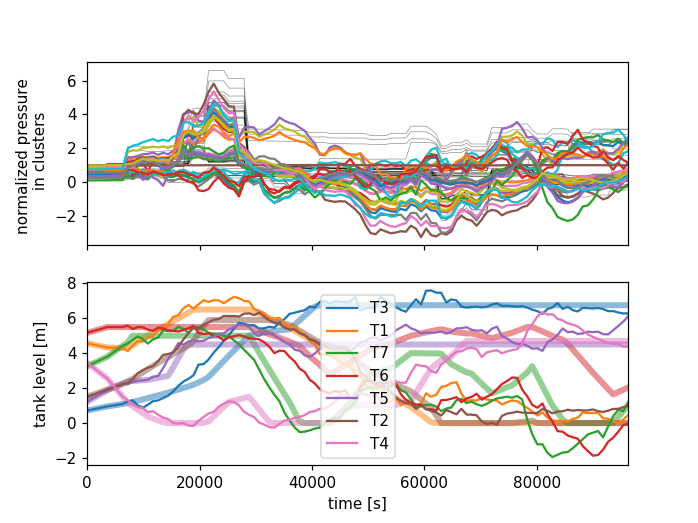

Text(0.5, 0, 'time [s]')

In [41]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_res['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1])

ax[0].set_xlim(0, sim_res.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

# Linear Model

In [226]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [227]:
x0 = sys_states.head(n_arx).to_numpy()
u0 = sys_inputs.head(n_arx-1).to_numpy()
t0 = sys_states.head(n_arx).index.to_numpy()

nsim_lin = narx_simulator(linear_reg, n_arx, input_scaling, output_scaling, input_offset, output_offset, x0, u0, t0)

In [228]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[n_arx+1+k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


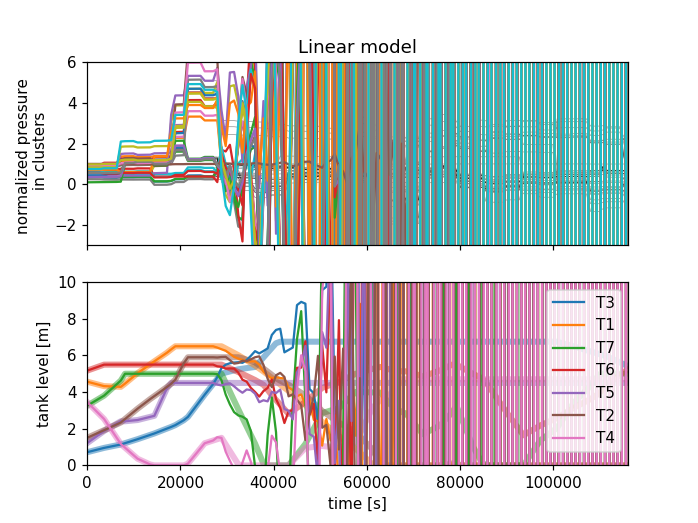

(0, 10)

In [229]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_res_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1])

ax[0].set_title('Linear model')
ax[0].set_xlim(0, sim_res_lin.index.max())
ax[0].set_ylim(-3, 6)

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

ax[1].set_ylim(0, 10)

# Create full training data set:

## Load data

In [ ]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/'
file_list = os.listdir(data_path)[:10]
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

In [ ]:
nn_input, nn_output = get_data(file_list, 10)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input, nn_output, test_size=0.2)

## Save everything

Pack everything needed for training in a .pkl file:

In [ ]:
training_dict = {
    'X_train': X_train,
    'X_test': X_test,
    'Y_train': Y_train,
    'Y_test': Y_test,
    'cluster_labels': cluster_labels,
    'pressure_factor': pressure_factor
}

with open('./training_data/training_setup_narx4.pkl', 'wb') as f:
    results = pickle.dump(training_dict, f)

# Test external model:

In [43]:
model_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/models/01_series/'
model_name = '030_model_01'
model_ext = keras.models.load_model(model_path+model_name+'.h5')

with open(model_path+model_name+'_aux.pkl', 'rb') as f:
    model_param = pickle.load(f)

In [49]:
model_param.keys()
x_scaling = model_param['x_scaling']
y_scaling = model_param['y_scaling']
x_offset = model_param['x_offset']
y_offset = model_param['y_offset']

n_arx = 6

x0 = sys_states.head(n_arx).to_numpy()
u0 = sys_inputs.head(n_arx-1).to_numpy()
t0 = sys_states.head(n_arx).index.to_numpy()

nsim = narx_simulator(model_ext, n_arx, x_scaling, y_scaling, x_offset, y_offset, x0, u0, t0)

In [50]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[n_arx+1+k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


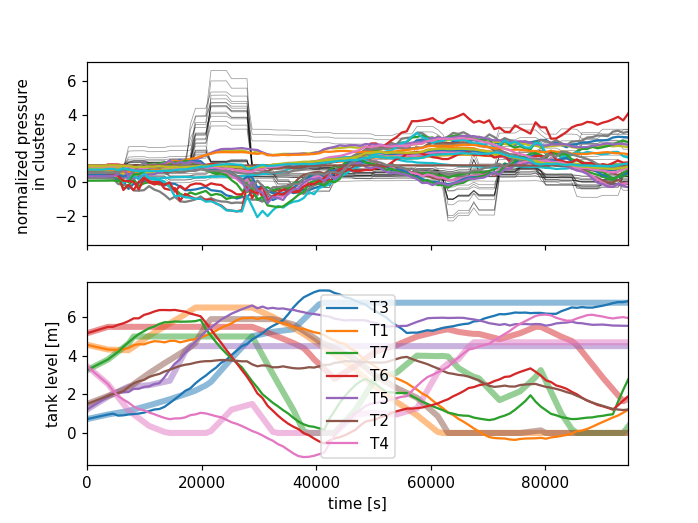

Text(0.5, 0, 'time [s]')

In [52]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_res['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1])

ax[0].set_xlim(0, sim_res.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')